In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
import os
import scipy.sparse as sprs
from scipy.sparse import lil_matrix
from collections import Counter
from nltk.corpus import stopwords

## 1. Naive Bayes

In [2]:
def preprocess_txt(text):

    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)

    # convert text to lowercase
    text = text.strip().lower()

    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    stop_words = set(stopwords.words('english')) # setting stopwords of English language
    words = text.split() # create a list of words
    filtered = ' '.join([word for word in words if not word in stop_words]) # removing stopwords
    return filtered

In [3]:
#cleaning the reviews from html tags, urls, stopwords and punctutation
df = pd.read_csv("IMDB Dataset.csv")
df['review'] = df['review'].apply(preprocess_txt)

In [4]:
class NLPModels:
    def __init__(self, col):
        self.col = col #column in which text data is stored
        
    def fit(self):
        self.count_words_across_document = {} #this is used to track the number of comments which contain a particular word
        self.list_words_sentences = [] #this list tracks word counts of each comment
        for sent in self.col: #iterating over each comment
            count_in_sentence = {} #this tracks the word seen in comment so far and its count
            for word in sent.split(): #iterating over each word in a comment
                
                #if word is already in dictionary increase the count else make a new key
                if word in self.count_words_across_document:
                    self.count_words_across_document[word]+=1
                    
                elif word not in self.count_words_across_document:
                    self.count_words_across_document[word]=1
                
                #this tracks word in each comment only
                if word in count_in_sentence:
                    count_in_sentence[word]+=1

                elif word not in count_in_sentence:
                    count_in_sentence[word]=1
            
            #make a list containing all the words across all comments
            self.list_words_sentences.append(count_in_sentence)
            
        #to make a two way connection between going from words to index or vice versa
        self.idx_to_word= {i:w for i,w in enumerate(self.count_words_across_document)}
        self.word_to_idx = {w:i for i,w in enumerate(self.count_words_across_document)}
        self.vocab_size = len(self.count_words_across_document) #number of unique words
            
    def BOW(self):
        bow = sprs.lil_matrix((1,self.vocab_size)) #sparse matrix as they are more efficent
        for sent in self.list_words_sentences: #iterate over each comment words dictionary
            rep = sprs.lil_matrix((1,self.vocab_size)) #empty matrix to store the final representation of the word
            for word, count in sent.items(): #iterating ober each word
                rep[0,self.word_to_idx[word]]=count #replacing the count in the representation matrix of that word
            bow = sprs.vstack([bow,rep]) #concatenate the matrix vertically to obtain one big matrix of size mxd
        return bow.toarray()[1:,:] 
    
    def TF_IDF(self):
        tokenized_docs,vocab,word_index=self.vocab_index(self.col)
        word_counts = Counter([word for doc in tokenized_docs for word in set(doc)])

        tf_matrix=lil_matrix((len(tokenized_docs),len(vocab)),dtype=np.float64)

        for i,doc in enumerate(tokenized_docs):
            for word in doc:
                tf_matrix[i,word_index[word]]=doc.count(word)

        idf_matrix = lil_matrix((len(vocab),len(vocab)),dtype=np.float64)

        for i,word in enumerate(vocab):
            idf_matrix[i,i]=np.log((len(tokenized_docs)+1)/word_counts[word])

        tf_idf_matrix=tf_matrix*idf_matrix
        return tf_idf_matrix.toarray()

    def vocab_index(self,X):
        tokenized_docs=[preprocess_txt(X.iloc[i]).split() for i in range(self.col.shape[0])]
        vocab=set([word for doc in tokenized_docs for word in doc])
        word_index = {word :i for i,word in enumerate(vocab)}
        return tokenized_docs,vocab,word_index

In [5]:
class NaiveBayes:
    def __init__ (self, alpha, vocab_size):
        self.alpha = alpha #smoothing parameter alpha
        self.vocab_size = vocab_size #vocab size of the words
        
    def fit(self, X, y):
        self.X = X #store the features
        self.y = y #store the targets
        m,n = self.X.shape
        
        #num classes and counts of unique classes in data
        self.classes, counts = np.unique(self.y,return_counts=True)
        n_classes = len(self.classes)
        
        #To store conditional probability of all the words
        self.cond_prob = np.zeros(shape=(n,n_classes))
        
        #To store prior probability of all the words 
        self.prior_prob = [cnt/m for cnt in counts]
        
        #iterate over each class
        for cls in self.classes:
            idx = self.y==cls #indices of all instances which belong to particular class
            sub_x = self.X[idx,:] #sample the dataset of all observation belonging to particular class
            
            #calculate the conditional probability using laplacian smoothing
            self.cond_prob[:,cls] = (sub_x.sum(axis=0) + self.alpha)/(sub_x.sum() + self.alpha * self.vocab_size)
        
    def predict(self,X):
        preds = [] #to store the predictions
        for x in X: #iterative over all test instances
            class_prob = [] #store probability for each instance
            for cls in self.classes: #iterate over all classes
                idx = self.y == cls #store indices of particular class samples
                sub_x = self.X[idx,:] #sample the observation belonging to particular class
                
                #to calculate the probability
                likelihood = np.multiply(np.log(self.cond_prob[:,cls].reshape(1,-1)),x.reshape(1,-1))
                prob = np.sum(likelihood) + np.log(self.prior_prob[cls])
                
                #store the probability of belonging to each class
                class_prob.append(prob)
            
            #the class with maximum probability is the class of an instance
            preds.append(np.argmax(class_prob))
        return preds

Here we will restrict our analysis to first 1000 reviews only to avoid getting any out of memory errors

In [6]:
#let's make the model using only the first 1000 reviews, the code will remain same for the analysis over whole data
n = NLPModels(df['review'].iloc[:1000]) 
#fit the model
n.fit()
#obtain the BOW representation
bow_representation = n.BOW()
#obtain TF-IDF representation
tfidf_representation = n.TF_IDF()

In [7]:
y = np.where(df.iloc[:1000,-1]=='positive',1,0) #to make reviews binary where 1=positive and 0=negative review
#first using the bow representation
X_train, X_test, y_train, y_test = train_test_split(bow_representation,y,random_state=42, test_size=0.2)

Now training our 1000 samples with bag of words representation on the Naive Bayes Classifier

In [8]:
N = NaiveBayes(alpha=1,vocab_size=n.vocab_size)
N.fit(X_train,y_train)
print('The Accuracy of the model while using BOW on test set is',accuracy_score(y_test,N.predict(X_test)))

The Accuracy of the model while using BOW on test set is 0.795


Let's compare the performance of our implementation with the Sklearn's implementation

In [9]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('The Accuracy of the Sklearn model while using BOW on test set is',accuracy_score(y_test,nb.predict(X_test)))

The Accuracy of the Sklearn model while using BOW on test set is 0.795


We can see that the Accuracy of our model and the accuracy of Sklearn's implementation is same

In [10]:
#let's try with TF-IDF representation now
X_train, X_test, y_train, y_test = train_test_split(tfidf_representation,y,random_state=42, test_size=0.2)

In [11]:
N = NaiveBayes(alpha=1,vocab_size=n.vocab_size)
N.fit(X_train,y_train)
print('The Accuracy of the model while using TF-IDF on test set is',accuracy_score(y_test,N.predict(X_test)))

The Accuracy of the model while using TF-IDF on test set is 0.735


In [12]:
#to compare from sklearn's implementation
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('The Accuracy of the Sklearn model while using TF-IDF on test set is',accuracy_score(y_test,nb.predict(X_test)))

The Accuracy of the Sklearn model while using TF-IDF on test set is 0.735


Again we can see that the Accuracy for Sklearn's implementation and our implementation is same

## 2. N-gram Language Model

First we have to read the data from all the files and store it at one place.

In [5]:
folder_name = 'english'
corpus = []
for fname in os.listdir(folder_name):
    fname = os.path.join(folder_name, fname)
    with open(fname,'r',encoding="utf8") as f:
        lines = f.readlines()
        for line in lines:
            text = line.lower()
            filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
            translate_dict = dict((c, " ") for c in filters)
            translate_map = str.maketrans(translate_dict)
            text = text.translate(translate_map)
            sent = ' '.join(text.strip().split())
            if len(sent)>1:
                cleaned_sent = '<s> '+sent+' </s>'
                corpus.append(cleaned_sent)

Great! we now have whole corpus proprocessed at one place, we can now proceed to building the n-gram model. let's divide into train and test set.

In [6]:
train_data, test_data = train_test_split(np.array(corpus),test_size=0.2,random_state=42)

In [142]:
class Ngram:
    def __init__ (self, n, alpha=1):
        self.n = n 
        self.alpha = alpha
        self.initials = ''
    
    def make_ngram(self, corpus):
        self.word_dict = {} #to store key value pairs
        self.key_counts = {} #to track count of keys
        self.togther_counts = {} #to track how many times they appeared togather
        for sent in corpus: #iterate over each sentence
            words = sent.split() 
            l = 0 #left pointer
            r = self.n-1 #right pointer
            
            while r<len(words): #iterate over each word
                key = tuple(words[l:r])
                val = words[r]
                togather = tuple(words[l:r] + [words[r]])
                
                if not key in self.word_dict:
                    self.word_dict[key] = {val:0}
                    self.key_counts[key] = 0
                    
                if not val in self.word_dict[key]:
                    self.word_dict[key][val] = 0
                   
                if not togather in self.togther_counts:
                    self.togther_counts[togather] = 0
                
                self.word_dict[key][val]+=1
                self.key_counts[key] +=1
                self.togther_counts[togather] +=1
                l+=1
                r+=1
                
            if not tuple([val]) in self.key_counts:
                self.key_counts[tuple([val])] = 0
            self.key_counts[tuple([val])] += 1
            self.build_vocab()
            
    def build_vocab(self):
        self.vocab = set()
        for k in self.key_counts.keys():
            for i in k:
                self.vocab.add(i) #this makes the vocabulory
    
    def generate_next_word(self, initials, c=0, max_sentence_len=100):
        #iterate over each word and find its prob but it's wiser to first calculate probs with words that appeared togather
        key = tuple(initials)
        
        #see if we have seen these initials before in corpus
        if key in self.word_dict:
            words = self.word_dict[key]
              
        #if not then we will pick some random words and check their probabilities with our initials
        else:
            idx = np.random.randint(len(self.vocab))
            word = list(self.vocab)
            words = {word[idx]:0}

        P = {}
        #see how many times this word appear with our last n words
        for word,count in words.items():
            if key in self.key_counts:
                prob = (count + self.alpha)/(self.key_counts[key]+self.alpha*(len(self.vocab)-1))
                P[word] = prob
            else:
                P[word] = (count + self.alpha)/(0+self.alpha*(len(self.vocab)-1))
        
        if len(self.initials) >max_sentence_len:
            return self.initials
        
        #pick the most probable word and predict it
        words_probabilities = sorted(P.items(), key=lambda x:x[1])
        #most probable word
        w, _ = words_probabilities[-1]

        if c==0:
            self.initials=initials

        self.initials += [w]

        if w == "</s>":
            return self.initials

        self.generate_next_word(self.initials[-self.n+1:],c+1)
            
    def measure_perplexity(self, sentences):
        P = [] #empty list to store probabilites
        N=0 #number of words
        for sent in sentences: #iterate over each sentence
            
            l = 0 #left pointer
            r = self.n-1 #right pointer
            
            #iterate till right pointer reaches the end of sentence
            while r<len(sent):
                N+=1 #number of words
                key = tuple(sent[l:r]) #the probability will be conditioned on the previous n words
                wi = sent[r] #the words whose probability we have to find

                #see if we have seen these initials before in corpus
                if key in self.word_dict:
                    #if the previous n words have occured togather get their count
                    w_ = self.key_counts[key]
                    
                    #if the word whose probability we have to find is in corpus, get its  count, else set the count to zero
                    if wi in self.word_dict[key]:
                        count = self.word_dict[key][wi]
                    else:
                        count = 0

                #if neither the initials nor the word has occured togather, we will set both to zero (laplace smoothing will take care)
                else:
                    count = 0
                    w_ = 0

                #to get the conditional probability of the word
                p=(count + self.alpha)/(w_+self.alpha*(len(self.vocab)-1))
                
                #to avoid getting smaller values take log
                P.append(np.log2(p))
                l+=1
                r+=1
        
        #transform it back and return 
        return 2**(-1/N*np.sum(P))

Let's first generate some text by our n-gram model with n=2,3,4,5. For keeping the scale of computations limited we will only train on first 1000 sentences and measure perplexity on them. This will give us good relative measure of the perplexity

In [72]:
#function which generate sentences
def generate_sentences(text,n,train_data=train_data,train_size=1000):
    ng = Ngram(n,alpha=1)
    ng.make_ngram(train_data[:train_size])
    initials = text.split()[:n-1]
    ng.generate_next_word(initials)
    return ' '.join(ng.initials)

Let's take a sample text as "european president has died" as a sample text and see what type sentences does our model generate

In [73]:
sample_text = 'european president has died'

In [74]:
#for n=2
generate_sentences(sample_text,n=2)

'european union </s>'

In [75]:
#for n=3
generate_sentences(sample_text,n=3)

'european president suitable war music persecute ms speaking has transferred attaches fit fated 0033 retiring meant aims outside exceed health drinking protocols 0023 simplified pro 8 shipping ambitions conclude issued straight incorporating impede recommendation 613 henry tanzania federalist 1 supervise discipline grey account internal human valuable is transposition creation disposal motorway enlarged involves sweden fund funding wrong encouraging considerate addressing desire rethink like proceedings dragging won politeness com snake snake torrey amounts participation accidents mud separates highlighting ages sincere drinking framework socialists recent renewables horizontal consideration assent concretely dilatory category want forgiven alerts adopted recourse bound scoreboard generosity resulted substance relocating'

In [76]:
#for n=4
generate_sentences(sample_text,n=4)

'european president has accommodate forgot shared established steer orders risks there sound how awaiting becomes rail believe cap complicated reason arguments centres taxpayer solidarity inter signed nevertheless positions stating determination livestock putting told attempt slavery ffh requirements offering communication treason person closed car portuguese copy moment st tolerated sacrificed csf lack derivatives ingredient post confidence tender arrested reforms though beds berger pre morals scale mountain contrary research havel alike forgot global pregnant flags against delegation europeans aim suffering defend improve success those dealing maintaining choices arlene treated talk gives involves politics danger marset building 200 saw electioneering planning debt murdered chances'

In [78]:
#for n=5
generate_sentences(sample_text,n=5)

'european president has died ten technical engenders fighting hospital reminded prospectuses totalitarianism debt concern decentralisation consultations decide planet conciliation implementation tax british south bases assure taken randzio better instincts tourist issue market policy investors invitation weakens prevailed primarily doing observance expresses though home promoted various almost affirmation indefensible kind thirdly upon fischler exert tomorrow remains higher disagreement forward permitted remaining optimum third grade assent main giving wall scrutinise reservoirs way cultural mankind acting communism emphasise upside constitutes concern unfair five governmental investors effect around organisations coastal sure 0015 signatories fora demonstrations allow goal globalisation denied note higher origin compensation prosecutor yugoslavia'

Now to check the perplexity of n=2,3,4,5 models

In [140]:
#again to keep the size of the computations in control we will calculate perplexity over first 1000 sentences of training set
train = train_data[:1000]
test = test_data[:1000]

In [145]:
#perplexity of n=2 model
ng = Ngram(n=2,alpha=1)
ng.make_ngram(train)
print('The Perplexity of n=2 model is', ng.measure_perplexity(test))

The Perplexity of n=2 model is 3931.2996248844865


In [146]:
#perplexity of n=2 model
ng = Ngram(n=3,alpha=1)
ng.make_ngram(train)
print('The Perplexity of n=3 model is', ng.measure_perplexity(test))

The Perplexity of n=3 model is 3899.0071524044215


In [147]:
#perplexity of n=2 model
ng = Ngram(n=4,alpha=1)
ng.make_ngram(train)
print('The Perplexity of n=4 model is', ng.measure_perplexity(test))

The Perplexity of n=4 model is 3899.000000000003


In [148]:
#perplexity of n=2 model
ng = Ngram(n=5,alpha=1)
ng.make_ngram(train)
print('The Perplexity of n=5 model is', ng.measure_perplexity(test))

The Perplexity of n=5 model is 3897.999999999988


Note: We can observe the decreasing perplexity here, note that the perplexity is calculated on portion of train and test data, also the data was randomly sampled into training and test set. So a large value of perplexity does not neccessarily mean that it is wrong.

## 3. Latent Dirichlet Allocation

In [28]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import remove_stopwords
import spacy
from wordcloud import WordCloud,STOPWORDS
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('papers.csv')

First we will clean up the paper text, and remove all the unwanted columns from the dataset

In [4]:
papers_data = df.iloc[:100,:].copy()

In [5]:
#define a tokenizer instance which also removes the punctuation and lowercase the words
def tokenizer(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

Let's make a word cloud first to see which are the most common words in the paper

In [6]:
string = ''
processed_text = tokenizer(papers_data.iloc[:,-1])
for sent in processed_text:
    text = ' '.join(sent)
    string = string + text +' '

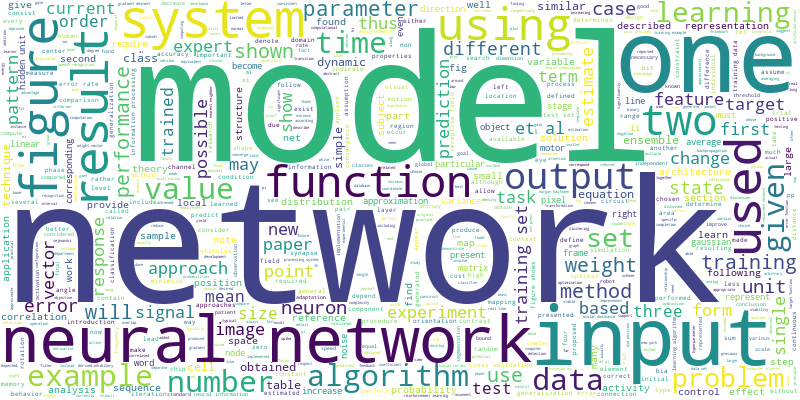

In [155]:
#to cater stopwords
stopwords = set(STOPWORDS)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3,
                      contour_color='steelblue',stopwords=stopwords,
                      width = 800, height = 400)
# Generate a word cloud
wordcloud.generate(string)
# Visualize the word cloud
wordcloud.to_image()

Conclusion: As expected we can see that words like model, neural network, input, algorithms are very prevalent.

Let's make one word cloud for the title of the papers too

In [35]:
string = ''
processed_text = tokenizer(papers_data.iloc[:,2])
for sent in processed_text:
    text = ' '.join(sent)
    string = string + text +' '

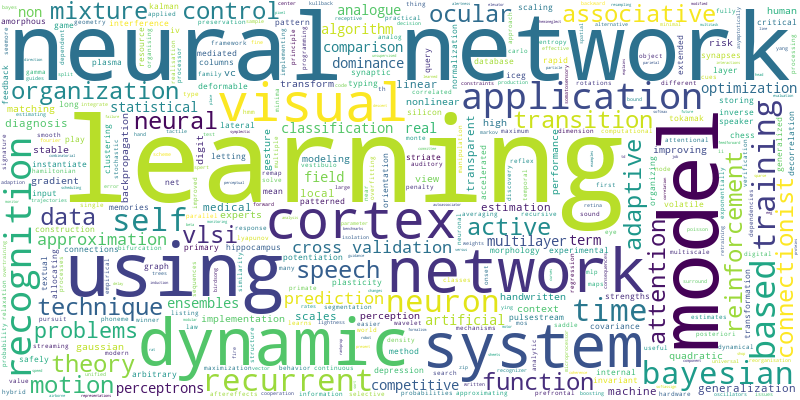

In [36]:
#to cater stopwords
stopwords = set(STOPWORDS)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,
                      contour_color='steelblue',stopwords=stopwords,
                      width = 800, height = 400)
# Generate a word cloud
wordcloud.generate(string)
# Visualize the word cloud
wordcloud.to_image()

Conclusion: Even on the title of the papers, we can see the similar words. However, this make sense because the title complements the paper text

Now let's move towards building the model

In [9]:
# Now we have to get rid of stopwords
Corpus = []
processed_text = tokenizer(papers_data.iloc[:,-1])
for sentence in processed_text:
    sent = []
    for word in sentence:
        if not word in STOPWORDS:
            sent.append(word)
    Corpus.append(sent)

In [14]:
#make dictionary for word to index and index to word mapping
id2word = corpora.Dictionary(Corpus)
#to convert our word based on the frequencey of their occurance
freq_rep = [id2word.doc2bow(sent) for sent in Corpus]

Now it is time to build the LDA model. We will first sort the papers into 10 topics.

In [47]:
lda_model = LdaModel(corpus=freq_rep,
                    id2word=id2word,
                    num_topics=15)

In [48]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[freq_rep]

[(0,
  '0.006*"one" + 0.005*"learning" + 0.005*"function" + 0.004*"neural" + '
  '0.004*"model" + 0.004*"input" + 0.004*"used" + 0.004*"networks" + '
  '0.004*"network" + 0.004*"figure"'),
 (1,
  '0.009*"network" + 0.006*"learning" + 0.005*"function" + 0.005*"model" + '
  '0.005*"neural" + 0.005*"figure" + 0.005*"set" + 0.005*"training" + '
  '0.004*"system" + 0.004*"input"'),
 (2,
  '0.010*"learning" + 0.005*"algorithm" + 0.005*"input" + 0.005*"figure" + '
  '0.004*"set" + 0.004*"training" + 0.004*"using" + 0.004*"data" + '
  '0.004*"function" + 0.004*"model"'),
 (3,
  '0.005*"neural" + 0.004*"network" + 0.004*"data" + 0.004*"one" + '
  '0.004*"error" + 0.004*"time" + 0.004*"used" + 0.004*"training" + '
  '0.004*"function" + 0.004*"using"'),
 (4,
  '0.009*"neural" + 0.008*"network" + 0.007*"data" + 0.006*"set" + '
  '0.005*"system" + 0.005*"figure" + 0.005*"learning" + 0.005*"input" + '
  '0.005*"using" + 0.005*"time"'),
 (5,
  '0.006*"learning" + 0.005*"neural" + 0.005*"model" + 0.00

Let's calculate the perplexity of the model

In [55]:
print('Perplexity of the model is:',lda_model.log_perplexity(freq_rep))  

Perplexity of the model is: -9.254690889521202


Now, let's visualize the topics

In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, freq_rep, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.000281 -0.011965       1        1  18.190530
4     -0.002946 -0.004539       2        1  15.073667
8     -0.002977 -0.007086       3        1  14.075978
10     0.004246  0.000263       4        1  12.399110
1     -0.003031 -0.004667       5        1  10.863219
6     -0.001500 -0.000580       6        1   5.909490
7     -0.008006 -0.005282       7        1   4.974420
14     0.009763 -0.001810       8        1   4.350962
5      0.010451  0.007431       9        1   2.934447
12     0.005849 -0.000219      10        1   2.899778
0     -0.003507  0.004201      11        1   2.507935
3     -0.010674  0.009312      12        1   2.113484
11     0.005372  0.002182      13        1   1.261843
9     -0.007144  0.009412      14        1   1.244899
2      0.004385  0.003348      15        1   1.200239, topic_info=          Term        Freq       Total Category  logprob  loglift
415   learning  979.000000  979.000000  Default  30.0000  30.0000
495     neural  984.000000  984.000000  Default  29.0000  29.0000
378      input  757.000000  757.000000  Default  28.0000  28.0000
314   function  790.000000  790.000000  Default  27.0000  27.0000
1029    figure  674.000000  674.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
244      error    4.940635  558.526738  Topic15  -6.0055  -0.3052
495     neural    5.771885  984.900129  Topic15  -5.8500  -0.7169
787       time    4.941661  653.017195  Topic15  -6.0053  -0.4613
1283      will    4.218476  358.665366  Topic15  -6.1636  -0.0203
510     number    4.300039  438.891506  Topic15  -6.1444  -0.2030

[1270 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
12781      1  0.183995  accelerometers
12781      2  0.367990  accelerometers
1294       1  0.413541            acid
1294       2  0.137847            acid
1294       3  0.068924            acid
...      ...       ...             ...
7161       2  0.115626          zohary
7161       3  0.115626          zohary
7161       4  0.115626          zohary
7161       6  0.115626          zohary
7161      11  0.115626          zohary

[5346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 9, 11, 2, 7, 8, 15, 6, 13, 1, 4, 12, 10, 3])

Now let's see each topic in detail

In [68]:
topics = [lda_model[freq_rep[i]] for i in range(len(papers_data))]

In [69]:
#function to convert each topic into dataframe
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [71]:
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=15) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

<AxesSubplot:>

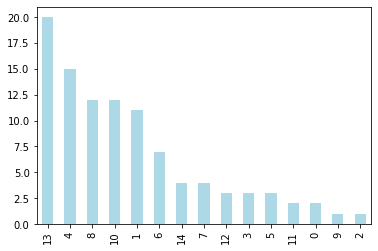

In [73]:
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

Conclusion: Here we can see that the most number of papers belong to the Topic 13 while the least number belong to Topic 2 and 9

References: 
1. https://www.youtube.com/watch?v=O2L2Uv9pdDA
2. https://youtu.be/UUdGPzmRTyw
3. https://youtu.be/Vc2C1NZkH0E
4. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
5. https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
6. https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb